## Initializing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use("seaborn-dark")

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.metrics import classification_report_imbalanced

import statsmodels.api as sm
import statsmodels.formula.api as smf

import xgboost as xgb
import lightgbm as lgb

from flaml import AutoML

## Importing Data

In [2]:
df = pd.read_csv('coding_round_data.csv')

### Fixing import issues

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
for col in ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Month']:
    df[col] = df[col].astype('category')

for col in ['Weekend', 'Revenue']:
    df[col] = df[col].astype('int')

## Splitting Data

Using a stratified split as the data is very imbalanced  
Train = 80%, Val = 10%, Test = 10%

In [5]:
df_train, df_test = train_test_split(df, stratify=df['Revenue'], test_size=0.10, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['Revenue'], test_size=1/9, random_state=42)

## Column Manipulation

In [6]:
nominal_features = ['Month','OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend']
nominal_transformer = OneHotEncoder(handle_unknown="ignore")

page_duration_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
ss_transformer = StandardScaler()

ga_rates_features = ['BounceRates', 'ExitRates']

preprocessor = ColumnTransformer(
    transformers=[
        ("nominal", nominal_transformer, nominal_features),
        ("page_duration", ss_transformer, page_duration_features),
        ("ga_rates", ss_transformer, ga_rates_features),
    ],
    sparse_threshold=0,
    remainder='passthrough'
)

preprocessor.fit(df_train)

df_train = pd.DataFrame(preprocessor.transform(df_train), columns=preprocessor.get_feature_names_out())
df_val = pd.DataFrame(preprocessor.transform(df_val), columns=preprocessor.get_feature_names_out())
df_test = pd.DataFrame(preprocessor.transform(df_test), columns=preprocessor.get_feature_names_out())

In [7]:
X_train = df_train.drop(columns='remainder__Revenue')
y_train = df_train[['remainder__Revenue']]

X_val = df_val.drop(columns='remainder__Revenue')
y_val = df_val[['remainder__Revenue']]

X_test = df_test.drop(columns='remainder__Revenue')
y_test = df_test[['remainder__Revenue']]

## Modelling

There are 2 main approaches that I will be taking for modelling. Their results will be compared on the validation set to decide a final approach through the F1-score of the positive class (as the goal is to predict whether a user makes a purchase or not).

After choosing an approach, I will go ahead with model selection and tuning the hyperparameters.  
The final model will be evaluated on the test set to provide an unbaised estimate of its performance on unseen data.

### Approach 1 - Logistic Regression w/ L1 Regularization

Implemented using statsmodels

In [8]:
formula = "remainder__Revenue ~ " + " + ".join(X_train)

LR_model = smf.logit(formula=formula, data=df_train).fit_regularized(method='l1')
LR_model.summary()

/home/kavish/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/kavish/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.286191599843355
            Iterations: 487
            Function evaluations: 495
            Gradient evaluations: 487


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     remainder__Revenue   No. Observations:                 9864
Model:                          Logit   Df Residuals:                     9789
Method:                           MLE   Df Model:                           74
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                  0.3356
Time:                        19:57:49   Log-Likelihood:                -2823.0
converged:                       True   LL-Null:                       -4249.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.1836   1.48e+06  -1.48e-06      1.000    -2.9e+06     2.9e+06
nominal__Month_Aug                         0.1609   2.09e+06   7.71e-08      1.000   -4.09e+06    4.09e+06
nominal__Month_Dec                        -0.5800   2.08e+06  -2.79e-07      1.000   -4.07e+06    4.07e+06
nominal__Month_Feb                        -1.2774   2.11e+06  -6.05e-07      1.000   -4.14e+06    4.14e+06
nominal__Month_Jul                         0.1823    2.1e+06   8.69e-08      1.000   -4.11e+06    4.11e+06
nominal__Month_June                       -0.3670   2.09e+06  -1.76e-07      1.000   -4.09e+06    4.09e+06
nominal__Month_Mar                        -0.3864   2.09e+06  -1.84e-07      1.000   -4.11e+06    4.11e+06
nominal__Month_May                        -0.3565    2.1e+06   -1.7e-07      1.000   -4.11e+06    4.11e+06
nominal__Month_Nov                         0.5742   2.09e+06   2.75e-07      1.000    -4.1e+06     4.1e+06
nominal__Month_Oct                         0.0980   2.09e+06   4.68e-08      1.000   -4.11e+06    4.11e+06
nominal__Month_Sep                         0.1398   2.08e+06   6.71e-08      1.000   -4.08e+06    4.08e+06
nominal__OperatingSystems_1               -0.3060   2.05e+06  -1.49e-07      1.000   -4.02e+06    4.02e+06
nominal__OperatingSystems_2               -0.0312   2.05e+06  -1.52e-08      1.000   -4.02e+06    4.02e+06
nominal__OperatingSystems_3               -0.2797   2.06e+06  -1.36e-07      1.000   -4.04e+06    4.04e+06
nominal__OperatingSystems_4               -0.3495   2.05e+06   -1.7e-07      1.000   -4.02e+06    4.02e+06
nominal__OperatingSystems_5               -0.0357        nan        nan        nan         nan         nan
nominal__OperatingSystems_6               -1.6059   2.05e+06  -7.83e-07      1.000   -4.02e+06    4.02e+06
nominal__OperatingSystems_7                1.2586   2.05e+06   6.13e-07      1.000   -4.03e+06    4.03e+06
nominal__OperatingSystems_8               -0.6463   2.05e+06  -3.15e-07      1.000   -4.03e+06    4.03e+06
nominal__Browser_1                         0.0026   8.29e+05    3.1e-09      1.000   -1.62e+06    1.62e+06
nominal__Browser_2                        -0.2528   8.28e+05  -3.05e-07      1.000   -1.62e+06    1.62e+06
nominal__Browser_3                        -1.2409   8.35e+05  -1.49e-06      1.000   -1.64e+06    1.64e+06
nominal__Browser_4                        -0.1994   8.35e+05  -2.39e-07      1.000   -1.64e+06    1.64e+06
nominal__Browser_5                        -0.0265   8.33e+05  -3.18e-08      1.000   -1.63e+06    1.63e+06
nominal__Browser_6                        -0.3530   8.34e+05  -4.24e-07      1.000   -1.63e+06    1.63e+06
nominal__Browser_7                        -0.7390   8.31e+05  -8.89e-07      1.000   -1.63e+06    1.63e+06
nominal__Browser_8                        -0.3551   8.33e+05  -4.27e-07      1.000   -1.63e+06    1.63e+06
nominal__Browser_10            

As the classes are not balanced, the intercept/threshold needs to be scaled accordingly.

In [9]:
weights = y_train.value_counts()

threshold = weights[1]/weights[0]

LR_val_preds_raw = LR_model.predict(exog=X_val)
LR_val_preds = (LR_val_preds_raw > threshold).astype('int')

print(classification_report_imbalanced(y_val, LR_val_preds))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.87      0.70      0.91      0.78      0.62      1042
        1.0       0.50      0.70      0.87      0.59      0.78      0.60       191

avg / total       0.87      0.85      0.73      0.86      0.78      0.62      1233



### Approach 2 - Boosted Decision Trees

Implemented using XGBoost

In [10]:
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)  # To help tackle imbalanced classes

xgb_model = xgb.XGBClassifier().fit(X_train, y_train, sample_weight=sample_weights)

[19:57:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kavish/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kavish/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kavish/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

In [11]:
xgb_val_preds = xgb_model.predict(X_val)

print(classification_report_imbalanced(y_val, xgb_val_preds))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.91      0.70      0.93      0.80      0.65      1042
        1.0       0.58      0.70      0.91      0.63      0.80      0.62       191

avg / total       0.89      0.88      0.73      0.88      0.80      0.64      1233



## Results - Logistic Regression vs XGBoost

The results from both approaches are close with the logistic regression having an F1 score of 0.59 (for Revenue=True) to the 0.63 for XGBoost

Additionally, the precision for TP is significantly higher for XGBoost (0.58 vs 0.50) while the recall is the same

Based on these results, we can focus on using boosted decision trees

### Approach 3 - More(Different) Boosted Trees

Implemented LightGBM

In [12]:
lgb_model = lgb.LGBMClassifier().fit(X_train, y_train, sample_weight=sample_weights)

/home/kavish/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kavish/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
lgb_val_preds = lgb_model.predict(X_val)

print(classification_report_imbalanced(y_val, xgb_val_preds))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.91      0.70      0.93      0.80      0.65      1042
        1.0       0.58      0.70      0.91      0.63      0.80      0.62       191

avg / total       0.89      0.88      0.73      0.88      0.80      0.64      1233



## Results - LightGBM vs XGBoost

Since they both have matching results, I would prefer LightGBM due to its speed advantage, allowing for better scalability

## Hyperparameter tuning

Via FLAML

In [14]:
automl = AutoML()
settings = {
    "time_budget": 60,
    "metric": 'f1',
    "estimator_list": ['lgbm'],
    "task": 'classification',
    "seed": 42,
}
automl.fit(X_train=X_train, y_train=y_train['remainder__Revenue'], **settings)

[flaml.automl: 04-03 19:57:50] {2105} INFO - task = classification
[flaml.automl: 04-03 19:57:50] {2107} INFO - Data split method: stratified
[flaml.automl: 04-03 19:57:50] {2111} INFO - Evaluation method: holdout
[flaml.automl: 04-03 19:57:50] {2188} INFO - Minimizing error metric: 1-f1
[flaml.automl: 04-03 19:57:50] {2281} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 04-03 19:57:50] {2567} INFO - iteration 0, current learner lgbm
[flaml.automl: 04-03 19:57:50] {2697} INFO - Estimated sufficient time budget=387s. Estimated necessary time budget=0s.
[flaml.automl: 04-03 19:57:50] {2744} INFO -  at 0.2s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl: 04-03 19:57:50] {2567} INFO - iteration 1, current learner lgbm
[flaml.automl: 04-03 19:57:50] {2744} INFO -  at 0.2s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl: 04-03 19:57:50] {2567} INFO - iteration 2, current learner lgbm
[fl

[flaml.automl: 04-03 19:57:54] {2567} INFO - iteration 37, current learner lgbm
[flaml.automl: 04-03 19:57:54] {2744} INFO -  at 4.3s,	estimator lgbm's best error=0.2852,	best estimator lgbm's best error=0.2852
[flaml.automl: 04-03 19:57:54] {2567} INFO - iteration 38, current learner lgbm
[flaml.automl: 04-03 19:57:54] {2744} INFO -  at 4.3s,	estimator lgbm's best error=0.2852,	best estimator lgbm's best error=0.2852
[flaml.automl: 04-03 19:57:54] {2567} INFO - iteration 39, current learner lgbm
[flaml.automl: 04-03 19:57:54] {2744} INFO -  at 4.4s,	estimator lgbm's best error=0.2848,	best estimator lgbm's best error=0.2848
[flaml.automl: 04-03 19:57:54] {2567} INFO - iteration 40, current learner lgbm
[flaml.automl: 04-03 19:57:54] {2744} INFO -  at 4.5s,	estimator lgbm's best error=0.2848,	best estimator lgbm's best error=0.2848
[flaml.automl: 04-03 19:57:54] {2567} INFO - iteration 41, current learner lgbm
[flaml.automl: 04-03 19:57:54] {2744} INFO -  at 4.6s,	estimator lgbm's best

[flaml.automl: 04-03 19:58:00] {2567} INFO - iteration 76, current learner lgbm
[flaml.automl: 04-03 19:58:01] {2744} INFO -  at 10.7s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:01] {2567} INFO - iteration 77, current learner lgbm
[flaml.automl: 04-03 19:58:01] {2744} INFO -  at 10.8s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:01] {2567} INFO - iteration 78, current learner lgbm
[flaml.automl: 04-03 19:58:01] {2744} INFO -  at 10.9s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:01] {2567} INFO - iteration 79, current learner lgbm
[flaml.automl: 04-03 19:58:01] {2744} INFO -  at 11.0s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:01] {2567} INFO - iteration 80, current learner lgbm
[flaml.automl: 04-03 19:58:01] {2744} INFO -  at 11.2s,	estimator lgbm's

[flaml.automl: 04-03 19:58:07] {2567} INFO - iteration 115, current learner lgbm
[flaml.automl: 04-03 19:58:07] {2744} INFO -  at 17.4s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:07] {2567} INFO - iteration 116, current learner lgbm
[flaml.automl: 04-03 19:58:07] {2744} INFO -  at 17.4s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:07] {2567} INFO - iteration 117, current learner lgbm
[flaml.automl: 04-03 19:58:08] {2744} INFO -  at 17.7s,	estimator lgbm's best error=0.2715,	best estimator lgbm's best error=0.2715
[flaml.automl: 04-03 19:58:08] {2567} INFO - iteration 118, current learner lgbm
[flaml.automl: 04-03 19:58:08] {2744} INFO -  at 17.8s,	estimator lgbm's best error=0.2709,	best estimator lgbm's best error=0.2709
[flaml.automl: 04-03 19:58:08] {2567} INFO - iteration 119, current learner lgbm
[flaml.automl: 04-03 19:58:08] {2744} INFO -  at 17.9s,	estimator l

[flaml.automl: 04-03 19:58:10] {2567} INFO - iteration 154, current learner lgbm
[flaml.automl: 04-03 19:58:11] {2744} INFO -  at 20.8s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:11] {2567} INFO - iteration 155, current learner lgbm
[flaml.automl: 04-03 19:58:11] {2744} INFO -  at 20.8s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:11] {2567} INFO - iteration 156, current learner lgbm
[flaml.automl: 04-03 19:58:11] {2744} INFO -  at 20.9s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:11] {2567} INFO - iteration 157, current learner lgbm
[flaml.automl: 04-03 19:58:11] {2744} INFO -  at 21.1s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:11] {2567} INFO - iteration 158, current learner lgbm
[flaml.automl: 04-03 19:58:11] {2744} INFO -  at 21.1s,	estimator l

[flaml.automl: 04-03 19:58:14] {2567} INFO - iteration 193, current learner lgbm
[flaml.automl: 04-03 19:58:14] {2744} INFO -  at 24.3s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:14] {2567} INFO - iteration 194, current learner lgbm
[flaml.automl: 04-03 19:58:14] {2744} INFO -  at 24.5s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:14] {2567} INFO - iteration 195, current learner lgbm
[flaml.automl: 04-03 19:58:14] {2744} INFO -  at 24.6s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:14] {2567} INFO - iteration 196, current learner lgbm
[flaml.automl: 04-03 19:58:14] {2744} INFO -  at 24.7s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:14] {2567} INFO - iteration 197, current learner lgbm
[flaml.automl: 04-03 19:58:15] {2744} INFO -  at 24.7s,	estimator l

[flaml.automl: 04-03 19:58:18] {2567} INFO - iteration 232, current learner lgbm
[flaml.automl: 04-03 19:58:18] {2744} INFO -  at 28.3s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:18] {2567} INFO - iteration 233, current learner lgbm
[flaml.automl: 04-03 19:58:18] {2744} INFO -  at 28.5s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:18] {2567} INFO - iteration 234, current learner lgbm
[flaml.automl: 04-03 19:58:18] {2744} INFO -  at 28.6s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:18] {2567} INFO - iteration 235, current learner lgbm
[flaml.automl: 04-03 19:58:19] {2744} INFO -  at 28.7s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:19] {2567} INFO - iteration 236, current learner lgbm
[flaml.automl: 04-03 19:58:19] {2744} INFO -  at 28.7s,	estimator l

[flaml.automl: 04-03 19:58:22] {2567} INFO - iteration 271, current learner lgbm
[flaml.automl: 04-03 19:58:22] {2744} INFO -  at 32.5s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:22] {2567} INFO - iteration 272, current learner lgbm
[flaml.automl: 04-03 19:58:22] {2744} INFO -  at 32.6s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:22] {2567} INFO - iteration 273, current learner lgbm
[flaml.automl: 04-03 19:58:23] {2744} INFO -  at 32.7s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:23] {2567} INFO - iteration 274, current learner lgbm
[flaml.automl: 04-03 19:58:23] {2744} INFO -  at 32.8s,	estimator lgbm's best error=0.2691,	best estimator lgbm's best error=0.2691
[flaml.automl: 04-03 19:58:23] {2567} INFO - iteration 275, current learner lgbm
[flaml.automl: 04-03 19:58:23] {2744} INFO -  at 32.8s,	estimator l

[flaml.automl: 04-03 19:58:27] {2567} INFO - iteration 310, current learner lgbm
[flaml.automl: 04-03 19:58:27] {2744} INFO -  at 37.2s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl: 04-03 19:58:27] {2567} INFO - iteration 311, current learner lgbm
[flaml.automl: 04-03 19:58:27] {2744} INFO -  at 37.3s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl: 04-03 19:58:27] {2567} INFO - iteration 312, current learner lgbm
[flaml.automl: 04-03 19:58:27] {2744} INFO -  at 37.4s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl: 04-03 19:58:27] {2567} INFO - iteration 313, current learner lgbm
[flaml.automl: 04-03 19:58:27] {2744} INFO -  at 37.4s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl: 04-03 19:58:27] {2567} INFO - iteration 314, current learner lgbm
[flaml.automl: 04-03 19:58:27] {2744} INFO -  at 37.5s,	estimator l

[flaml.automl: 04-03 19:58:31] {2567} INFO - iteration 349, current learner lgbm
[flaml.automl: 04-03 19:58:31] {2744} INFO -  at 41.1s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:31] {2567} INFO - iteration 350, current learner lgbm
[flaml.automl: 04-03 19:58:31] {2744} INFO -  at 41.3s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:31] {2567} INFO - iteration 351, current learner lgbm
[flaml.automl: 04-03 19:58:31] {2744} INFO -  at 41.4s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:31] {2567} INFO - iteration 352, current learner lgbm
[flaml.automl: 04-03 19:58:31] {2744} INFO -  at 41.5s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:31] {2567} INFO - iteration 353, current learner lgbm
[flaml.automl: 04-03 19:58:31] {2744} INFO -  at 41.5s,	estimator l

[flaml.automl: 04-03 19:58:37] {2567} INFO - iteration 388, current learner lgbm
[flaml.automl: 04-03 19:58:37] {2744} INFO -  at 46.9s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:37] {2567} INFO - iteration 389, current learner lgbm
[flaml.automl: 04-03 19:58:37] {2744} INFO -  at 46.9s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:37] {2567} INFO - iteration 390, current learner lgbm
[flaml.automl: 04-03 19:58:37] {2744} INFO -  at 47.1s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:37] {2567} INFO - iteration 391, current learner lgbm
[flaml.automl: 04-03 19:58:37] {2744} INFO -  at 47.2s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:37] {2567} INFO - iteration 392, current learner lgbm
[flaml.automl: 04-03 19:58:37] {2744} INFO -  at 47.3s,	estimator l

[flaml.automl: 04-03 19:58:40] {2567} INFO - iteration 427, current learner lgbm
[flaml.automl: 04-03 19:58:40] {2744} INFO -  at 50.7s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:40] {2567} INFO - iteration 428, current learner lgbm
[flaml.automl: 04-03 19:58:41] {2744} INFO -  at 50.7s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:41] {2567} INFO - iteration 429, current learner lgbm
[flaml.automl: 04-03 19:58:41] {2744} INFO -  at 50.8s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:41] {2567} INFO - iteration 430, current learner lgbm
[flaml.automl: 04-03 19:58:41] {2744} INFO -  at 50.9s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:41] {2567} INFO - iteration 431, current learner lgbm
[flaml.automl: 04-03 19:58:41] {2744} INFO -  at 51.1s,	estimator l

[flaml.automl: 04-03 19:58:44] {2567} INFO - iteration 466, current learner lgbm
[flaml.automl: 04-03 19:58:44] {2744} INFO -  at 54.4s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:44] {2567} INFO - iteration 467, current learner lgbm
[flaml.automl: 04-03 19:58:44] {2744} INFO -  at 54.4s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:44] {2567} INFO - iteration 468, current learner lgbm
[flaml.automl: 04-03 19:58:44] {2744} INFO -  at 54.6s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:44] {2567} INFO - iteration 469, current learner lgbm
[flaml.automl: 04-03 19:58:44] {2744} INFO -  at 54.6s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:44] {2567} INFO - iteration 470, current learner lgbm
[flaml.automl: 04-03 19:58:45] {2744} INFO -  at 54.7s,	estimator l

[flaml.automl: 04-03 19:58:49] {2567} INFO - iteration 505, current learner lgbm
[flaml.automl: 04-03 19:58:49] {2744} INFO -  at 58.8s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:49] {2567} INFO - iteration 506, current learner lgbm
[flaml.automl: 04-03 19:58:49] {2744} INFO -  at 59.1s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:49] {2567} INFO - iteration 507, current learner lgbm
[flaml.automl: 04-03 19:58:49] {2744} INFO -  at 59.2s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:49] {2567} INFO - iteration 508, current learner lgbm
[flaml.automl: 04-03 19:58:49] {2744} INFO -  at 59.3s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 04-03 19:58:49] {2567} INFO - iteration 509, current learner lgbm
[flaml.automl: 04-03 19:58:49] {2744} INFO -  at 59.5s,	estimator l

In [15]:
best_estimator = automl.model.estimator

best_val_preds = best_estimator.predict(X_val)
print("Val set")
print(classification_report_imbalanced(y_val, best_val_preds))

print("-"*100)

best_test_preds = best_estimator.predict(X_test)
print("Test set")
print(classification_report_imbalanced(y_test, best_test_preds))

Val set
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.97      0.58      0.95      0.75      0.58      1042
        1.0       0.76      0.58      0.97      0.65      0.75      0.53       191

avg / total       0.90      0.91      0.64      0.90      0.75      0.57      1233

----------------------------------------------------------------------------------------------------
Test set
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.95      0.60      0.94      0.75      0.59      1042
        1.0       0.68      0.60      0.95      0.64      0.75      0.55       191

avg / total       0.89      0.89      0.65      0.89      0.75      0.58      1233



## Results - Final LightGBM model

Based on these results, we can expect a final F1 score of 0.64

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

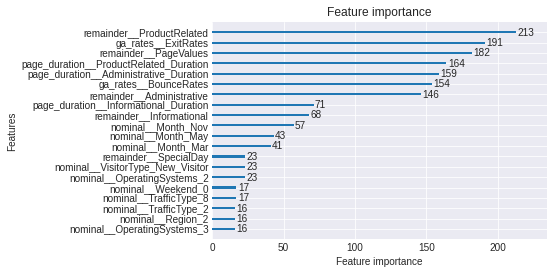

In [16]:
lgb.plot_importance(best_estimator, max_num_features=20)